In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# 1. Load dataset
file_path = '/content/drive/MyDrive/AAPL.csv'
df = pd.read_csv(file_path)

In [3]:
df.head(4)

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.26,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.95,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.45,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.39,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   1258 non-null   int64  
 1   symbol       1258 non-null   object 
 2   date         1258 non-null   object 
 3   close        1258 non-null   float64
 4   high         1258 non-null   float64
 5   low          1258 non-null   float64
 6   open         1258 non-null   float64
 7   volume       1258 non-null   int64  
 8   adjClose     1258 non-null   float64
 9   adjHigh      1258 non-null   float64
 10  adjLow       1258 non-null   float64
 11  adjOpen      1258 non-null   float64
 12  adjVolume    1258 non-null   int64  
 13  divCash      1258 non-null   float64
 14  splitFactor  1258 non-null   float64
dtypes: float64(10), int64(3), object(2)
memory usage: 147.6+ KB


In [5]:
df.shape

(1258, 15)

In [6]:
df.describe()

,Unnamed: 0,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03,1258.000000,1258.0
mean,628.500000,167.723998,169.230475,166.039780,167.548266,3.500397e+07,162.666715,164.131054,161.028013,162.493082,3.500397e+07,0.010477,1.0
std,363.297628,56.850796,57.500128,56.006773,56.612707,1.729100e+07,58.733820,59.402842,57.869246,58.494560,1.729100e+07,0.083366,0.0
min,0.000000,90.340000,91.670000,89.470000,90.000000,1.136204e+07,84.954351,86.205062,84.136216,84.634620,1.136204e+07,0.000000,1.0
25%,314.250000,116.327500,117.405000,115.602500,116.482500,2.359205e+07,109.484490,110.393556,107.962457,109.135002,2.359205e+07,0.000000,1.0
50%,628.500000,160.485000,162.080000,158.974250,160.345000,3.064771e+07,154.710645,156.091874,153.054341,154.410017,3.064771e+07,0.000000,1.0
75%,942.750000,199.785000,201.277500,198.170000,199.520000,4.100487e+07,196.960053,198.428438,195.281553,196.452903,4.100487e+07,0.000000,1.0
max,1257.000000,327.200000,327.850000,323.350000,324.730000,1.622063e+08,326.337147,326.357095,322.497300,323.873661,1.622063e+08,0.820000,1.0


In [7]:
df.isnull().sum()

,0
Unnamed: 0,0
symbol,0
date,0
close,0
high,0
low,0
open,0
volume,0
adjClose,0
adjHigh,0


In [8]:
df.duplicated().sum()

np.int64(0)

In [9]:
# Ensure date sorting if date column exists
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')

In [10]:
# Select closing price
df1 = df[['close']].copy()

In [11]:
# 2. Scale only on training set
training_size = int(len(df1) * 0.65)
train_df = df1[:training_size]
test_df = df1[training_size:]

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_df)
test_scaled = scaler.transform(test_df)

In [13]:
# 3. Create dataset function
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

In [14]:
time_step = 60
X_train, y_train = create_dataset(train_scaled, time_step)
X_test, y_test = create_dataset(test_scaled, time_step)

In [15]:
# Reshape to [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [16]:
# 4. Build LSTM model with Dropout
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(32))
model.add(Dense(1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
model.compile(
    loss='mean_squared_error',
    optimizer='adam',
    )

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,369 (243.63 KB)

 Trainable params: 62,369 (243.63 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Early stopping to prevent overfitting
es = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
    )

In [20]:
# 5. Train the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[es]
    )

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.0780 - val_loss: 0.0317
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0069 - val_loss: 0.0385
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0026 - val_loss: 0.0312
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0020 - val_loss: 0.0250
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0023 - val_loss: 0.0214
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0024 - val_loss: 0.0230
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0019 - val_loss: 0.0257
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0019 - val_loss: 0.0397
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0026 - val_loss: 0.0159
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0020 - val_loss: 0.0159
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0019 - val_loss: 0.0168
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

In [21]:
# 6. Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [22]:
# 7. Inverse transform
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
train_predict_inv = scaler.inverse_transform(train_predict)
test_predict_inv = scaler.inverse_transform(test_predict)

In [23]:
# 8. RMSE calculation
train_rmse = math.sqrt(mean_squared_error(y_train_inv, train_predict_inv))
test_rmse = math.sqrt(mean_squared_error(y_test_inv, test_predict_inv))
train_rmse_pct = (train_rmse / np.mean(y_train_inv)) * 100
test_rmse_pct = (test_rmse / np.mean(y_test_inv)) * 100

In [24]:
print(f"Train RMSE: {train_rmse:.2f} ({train_rmse_pct:.2f}%)")
print(f"Test RMSE: {test_rmse:.2f} ({test_rmse_pct:.2f}%)")

Train RMSE: 4.65 (3.39%)
Test RMSE: 11.10 (4.90%)


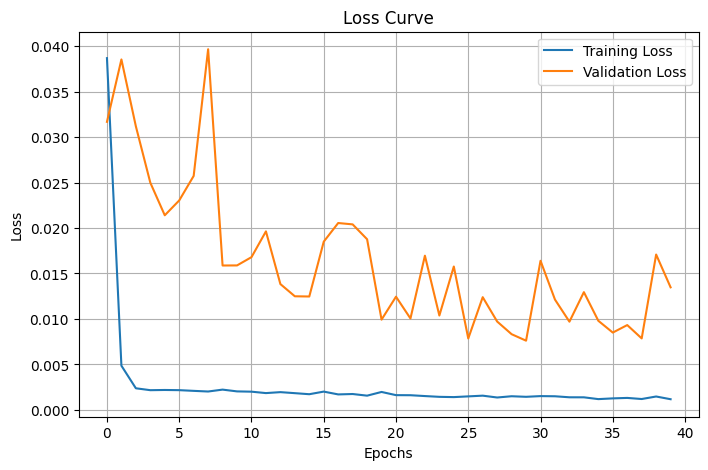

In [25]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
# 9. Plotting
look_back = time_step
train_predict_plot = np.empty_like(df1.values)
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back:len(train_predict) + look_back, :] = train_predict_inv
test_predict_plot = np.empty_like(df1.values)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (look_back * 2) + 1:len(df1) - 1, :] = test_predict_inv
test_predict_plot = np.empty_like(df1.values)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (look_back * 2) + 1:len(df1) - 1, :] = test_predict_inv


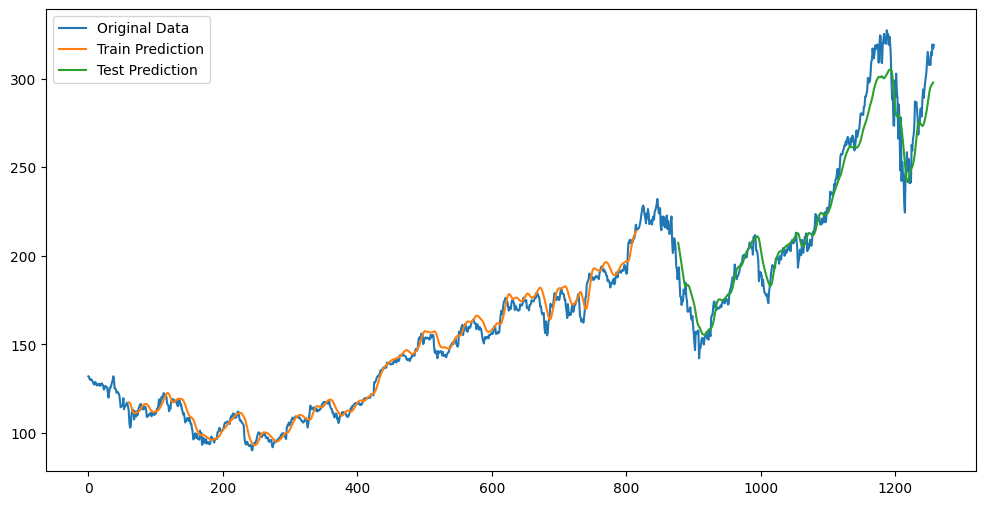

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(df1.values, label='Original Data')
plt.plot(train_predict_plot, label='Train Prediction')
plt.plot(test_predict_plot, label='Test Prediction')
plt.legend()
plt.show()

## ===== FUTURE PREDICTION  =====

In [32]:
# How many days you want to predict into the future
future_days = int(input('How many days you want to predict into the future: '))

# Take the last 'time_step' values from the test set
last_sequence = test_scaled[-time_step:]

future_predictions_scaled = []
current_input = last_sequence.reshape(1, time_step, 1)

for _ in range(future_days):
    # Predict next day
    next_scaled = model.predict(current_input, verbose=0)
    future_predictions_scaled.append(next_scaled[0, 0])

    # Slide the window forward
    current_input = np.append(current_input[:, 1:, :], next_scaled.reshape(1, 1, 1), axis=1)

# Inverse transform predictions to actual prices
future_predictions = scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1))

How many days you want to predict into the future: 30


##  ===== CREATE DATE RANGE FOR FUTURE =====

In [33]:
df['date'] = pd.to_datetime(df['date'])
last_date = df['date'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days, freq='B')  # 'B' = business days

In [34]:
# ===== DISPLAY FUTURE FORECAST =====
future_df = pd.DataFrame({'Date': future_dates, 'Predicted_Close': future_predictions.flatten()})
print(future_df)

                        Date  Predicted_Close
0  2020-05-25 00:00:00+00:00       299.146790
1  2020-05-26 00:00:00+00:00       298.877228
2  2020-05-27 00:00:00+00:00       297.675659
3  2020-05-28 00:00:00+00:00       295.794617
4  2020-05-29 00:00:00+00:00       293.503662
5  2020-06-01 00:00:00+00:00       291.023315
6  2020-06-02 00:00:00+00:00       288.510010
7  2020-06-03 00:00:00+00:00       286.063446
8  2020-06-04 00:00:00+00:00       283.740356
9  2020-06-05 00:00:00+00:00       281.569153
10 2020-06-08 00:00:00+00:00       279.560211
11 2020-06-09 00:00:00+00:00       277.713074
12 2020-06-10 00:00:00+00:00       276.022461
13 2020-06-11 00:00:00+00:00       274.479614
14 2020-06-12 00:00:00+00:00       273.074860
15 2020-06-15 00:00:00+00:00       271.797729
16 2020-06-16 00:00:00+00:00       270.637878
17 2020-06-17 00:00:00+00:00       269.584747
18 2020-06-18 00:00:00+00:00       268.628082
19 2020-06-19 00:00:00+00:00       267.758087
20 2020-06-22 00:00:00+00:00      

## ===== PLOT =====

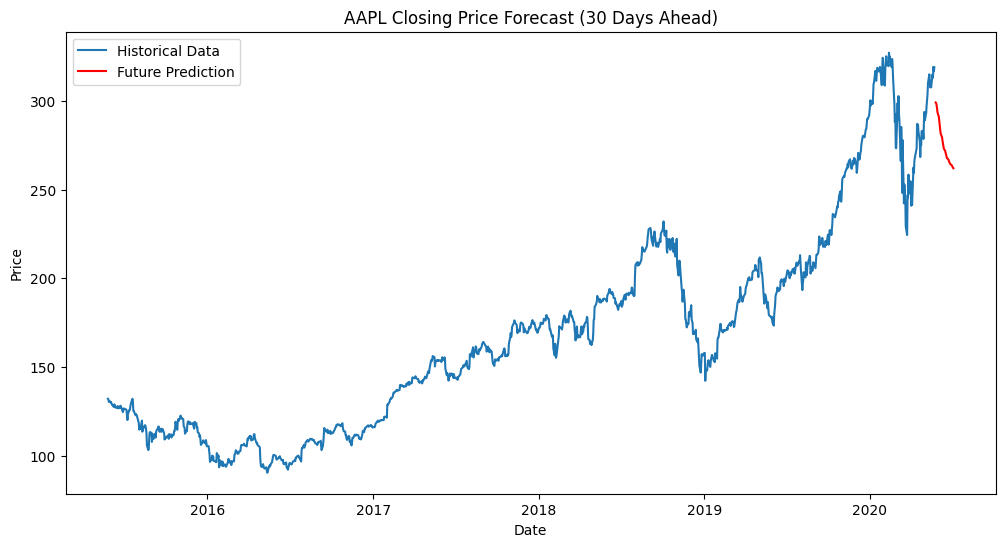

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['close'], label="Historical Data")
plt.plot(future_df['Date'], future_df['Predicted_Close'], label="Future Prediction", color='red')
plt.xlabel("Date")
plt.ylabel("Price")
plt.title(f"AAPL Closing Price Forecast ({future_days} Days Ahead)")
plt.legend()
plt.show()